<a href="https://colab.research.google.com/github/pianonyy/Machine-Learning/blob/master/Siamese_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import warnings
import numpy as np
from sklearn.utils.extmath import stable_cumsum
from sklearn.utils.validation import check_consistent_length
from sklearn.metrics import auc

In [ ]:


def qini_curve(y_true, uplift, treatment): #think about names uplift score?

    y_true, uplift, treatment = np.array(y_true), np.array(uplift), np.array(treatment)

    desc_score_indices = np.argsort(uplift, kind="mergesort")[::-1]

    y_true = y_true[desc_score_indices]
    treatment = treatment[desc_score_indices]
    uplift = uplift[desc_score_indices]

    y_true_ctrl, y_true_trmnt = y_true.copy(), y_true.copy()

    y_true_ctrl[treatment == 1] = 0
    y_true_trmnt[treatment == 0] = 0

    distinct_value_indices = np.where(np.diff(uplift))[0]
    threshold_indices = np.r_[distinct_value_indices, uplift.size - 1]

    #print(threshold_indices.size)

    num_trmnt = stable_cumsum(treatment)[threshold_indices]
    y_trmnt = stable_cumsum(y_true_trmnt)[threshold_indices]

    num_all = threshold_indices + 1

    num_ctrl = num_all - num_trmnt
    y_ctrl = stable_cumsum(y_true_ctrl)[threshold_indices]

    curve_values = y_trmnt - y_ctrl * np.divide(num_trmnt, num_ctrl, out=np.zeros_like(num_trmnt), where=num_ctrl != 0)
    if num_all.size == 0 or curve_values[0] != 0 or num_all[0] != 0:
       
        num_all = np.r_[0, num_all]
        curve_values = np.r_[0, curve_values]

    return num_all, curve_values

def perfect_qini_curve(y_true, treatment):
  
    check_consistent_length(y_true, treatment)
    n_samples = len(y_true)

    y_true, treatment = np.array(y_true), np.array(treatment)

    
    
    x_perfect, y_perfect = qini_curve(
            y_true, y_true * treatment - y_true * (1 - treatment), treatment
    )
    

    return x_perfect, y_perfect

def qini_auc_score(y_true, uplift, treatment, negative_effect=True):
   
    check_consistent_length(y_true, uplift, treatment)

    y_true, uplift, treatment = np.array(y_true), np.array(uplift), np.array(treatment)

    treatment_count = np.count_nonzero(treatment == 1)


    x_model, y_model = qini_curve(y_true, uplift, treatment)
    x_perfect, y_perfect = perfect_qini_curve(y_true, treatment)
    x_baseline, y_baseline = np.array([0, x_perfect[-1]]), np.array([0, y_perfect[-1]])
    
    # print(np.size(treatment))
    #x_baseline, y_baseline = np.array([np.arange(0, np.size(treatment))]), np.array([0, y_perfect[-1]])
    

    auc_score_baseline = auc(x_baseline, y_baseline)
    auc_score_perfect = auc(x_perfect, y_perfect) - auc_score_baseline
    auc_score_model = auc(x_model, y_model) - auc_score_baseline

    return auc_score_model


In [ ]:
import logging
from os.path import join as pjoin
from typing import Tuple

import pandas as pd
from sklearn.preprocessing import LabelEncoder

N_PURCHASES_ROWS = None
DATA_PATH = '/content/drive/MyDrive/' 
logger = logging.getLogger(__name__)


def load_clients() -> pd.DataFrame:
    return pd.read_csv(
        pjoin(DATA_PATH, 'clients.csv'),
        parse_dates=['first_issue_date', 'first_redeem_date'],
    )


def prepare_clients() -> Tuple[pd.DataFrame, LabelEncoder]:
    logger.info('Preparing clients...')
    clients = load_clients()
    client_encoder = LabelEncoder()
    clients['client_id'] = client_encoder.fit_transform(clients['client_id'])
    logger.info('Clients are ready')
    return clients, client_encoder


def load_products() -> pd.DataFrame:
    return pd.read_csv(pjoin(DATA_PATH, 'products.csv'))


def prepare_products() -> Tuple[pd.DataFrame, LabelEncoder]:
    logger.info('Preparing products...')
    products = load_products()
    product_encoder = LabelEncoder()
    products['product_id'] = product_encoder. \
        fit_transform(products['product_id'])

    products.fillna(-1, inplace=True)

    for col in [
        'level_1', 'level_2', 'level_3', 'level_4',
        'segment_id', 'brand_id', 'vendor_id',
    ]:
        products[col] = LabelEncoder().fit_transform(products[col].astype(str))
    logger.info('Products are ready')
    return products, product_encoder


def load_purchases() -> pd.DataFrame:
    logger.info('Loading purchases...')
    purchases = pd.read_csv(
        pjoin(DATA_PATH, 'purchases.csv'),
        nrows=N_PURCHASES_ROWS,
    )
    logger.info('Purchases are loaded')
    return purchases


def prepare_purchases(
        client_encoder: LabelEncoder,
        product_encoder: LabelEncoder,
) -> pd.DataFrame:
    logger.info('Preparing purchases...')
    purchases = load_purchases()

    logger.info('Handling n/a values...')
    purchases.dropna(
        subset=['client_id', 'product_id'],
        how='any',
        inplace=True,
    )
    purchases.fillna(-1, inplace=True)

    logger.info('Label encoding...')
    purchases['client_id'] = client_encoder.transform(purchases['client_id'])
    purchases['product_id'] = product_encoder.transform(purchases['product_id'])
    for col in ['transaction_id', 'store_id']:
        purchases[col] = LabelEncoder(). \
            fit_transform(purchases[col].astype(str))

    logger.info('Date and time conversion...')
    purchases['datetime'] = pd.to_datetime(
        purchases['transaction_datetime'],
        format='%Y-%m-%d %H:%M:%S',
    )
    purchases.drop(columns=['transaction_datetime'], inplace=True)

    logger.info('Purchases are ready')
    return purchases


def load_train() -> pd.DataFrame:
    return pd.read_csv(
        pjoin(DATA_PATH, 'uplift_train.csv'),
        index_col='client_id',
    )


def load_test() -> pd.DataFrame:
    return pd.read_csv(
        pjoin(DATA_PATH, 'uplift_test.csv'),
        index_col='client_id',
    )


In [ ]:
!unzip /content/drive/MyDrive/features.zip

Archive:  /content/drive/MyDrive/features.zip
  inflating: features.pkl            


In [ ]:
!pip install pickle5

     |████████████████████████████████| 133kB 11.9MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp36-cp36m-linux_x86_64.whl size=218610 sha256=d21963fc72ea059f08346758f300c522f6bff8b5eb010e89ae4b65764b17716b
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


In [ ]:
import pickle5
RANDOM_STATE = 12
from sklearn.model_selection import train_test_split

train = load_train()
indices_train = train.index
with open('features.pkl', 'rb') as f:
        features: pd.DataFrame = pickle5.load(f)

features.set_index('client_id', inplace=True)
X_train = features.loc[indices_train, :]



treatment_train = train.loc[indices_train, 'treatment_flg'].values
y_train = train.loc[indices_train, 'target'].values

X_train['treatment'] = treatment_train
X_train['target'] = y_train

X_train.loc[(X_train['target'] == 1) & (X_train['treatment'] == 1),'Z_trans'] = 2 
X_train.loc[(X_train['target'] == 0) & (X_train['treatment'] == 0),'Z_trans'] = -2
X_train.loc[X_train['Z_trans'].isnull(), 'Z_trans'] = 0

# Z_trans = X_train['Z_trans']


indices_learn, indices_valid = train_test_split(
        X_train.index,
        test_size=0.3,
        random_state = RANDOM_STATE,
)

all = X_train.copy()
X_train =all.loc[indices_learn,]
X_test = all.loc[indices_valid,]


treatment_train = X_train['treatment']
y_train = X_train['target']
Z_trans_train = X_train['Z_trans']

treatment_test = X_test['treatment']
y_test = X_test['target']
Z_trans_test = X_test['Z_trans']


X_train=X_train.drop('Z_trans',axis = 1)
X_train=X_train.drop('target',axis = 1)
X_train=X_train.drop('treatment',axis = 1)

X_test=X_test.drop('Z_trans',axis = 1)
X_test=X_test.drop('target',axis = 1)
X_test=X_test.drop('treatment',axis = 1)

print(treatment_train)
print(X_train)
print(X_test)

client_id
5803624422    1
20b7b05f7d    0
0c10e0113f    1
1761677f2d    1
aa188a0008    0
             ..
4ef8dd16ad    1
a54f58238b    1
2e7eeaca71    1
332b911361    1
c13eba9d88    1
Name: treatment, Length: 140024, dtype: int64
            gender_M  gender_F  ...  brand_id_nunique  vendor_id_nunique
client_id                       ...                                     
5803624422         0         0  ...                26                 20
20b7b05f7d         1         0  ...                54                 42
0c10e0113f         0         0  ...                41                 31
1761677f2d         0         0  ...                51                 47
aa188a0008         1         0  ...                24                 20
...              ...       ...  ...               ...                ...
4ef8dd16ad         0         1  ...               105                 86
a54f58238b         0         0  ...                33                 29
2e7eeaca71         0         0  ...   

In [ ]:
from sklearn.preprocessing import StandardScaler 
import numpy as np


scaler = StandardScaler()

X_train_0 = X_train.copy()
X_train_0['treatment'] = 0

X_train_1 = X_train.copy()
X_train_1['treatment'] = 1

X_train_1 = X_train_1.astype('float32')
X_train_1 = X_train_1.replace([np.inf, -np.inf], np.nan).fillna(0)
X_train_1 = scaler.fit_transform(X_train_1)

X_train_0 = X_train_0.astype('float32')
X_train_0 = X_train_0.replace([np.inf, -np.inf], np.nan).fillna(0)
X_train_0 = scaler.fit_transform(X_train_0)

X_test_0 = X_test.copy()
X_test_0['treatment'] = 0

X_test_1 = X_test.copy()
X_test_1['treatment'] = 1

X_test_1 = X_test_1.astype('float32')
X_test_1 = X_test_1.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test_1 = scaler.fit_transform(X_test_1)

X_test_0 = X_test_0.astype('float32')
X_test_0 = X_test_0.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test_0 = scaler.fit_transform(X_test_0)



/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


example of siamese network!!!!
 

..........................epoch = 0 ..........................
-29647747.917001788
..........................epoch = 1 ..........................
-29647747.917001788
..........................epoch = 2 ..........................
-29647747.917001788
..........................epoch = 3 ..........................
-29647747.917001788
..........................epoch = 4 ..........................
-29647747.917001788
..........................epoch = 5 ..........................
-29647747.917001788
..........................epoch = 6 ..........................
-29647747.917001788
..........................epoch = 7 ..........................
-29647747.917001788
..........................epoch = 8 ..........................
-29647747.917001788
..........................epoch = 9 ..........................
-29647747.917001788
..........................epoch = 10 ..........................
-29647747.917001788
..........................epoch = 11 ..........................
-29647747.917001788


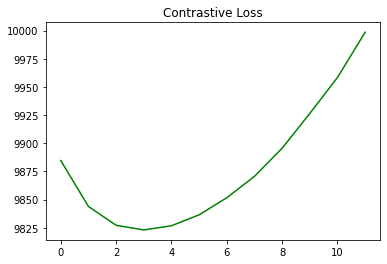

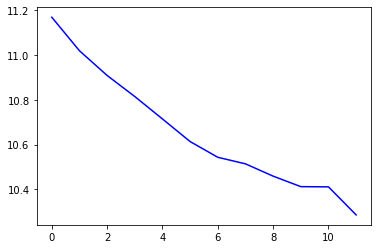

In [ ]:
from __future__ import print_function
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import random
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from statistics import mean

batch_size = 55   # Number of samples in each batch
epoch_num = 12      # Number of epochs to train the network
lr = 0.001        # Learning rate
import torch.nn.functional as F




class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(334, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.exp(F.log_softmax(x,dim=1))    # F.log_softmax = log( exp(x_i) / exp(x).sum() )
        #return x



model = Model()
alpha = 0.3


# calculate the number of batches per epoch
batch_per_ep = X_train.shape[0] // batch_size

# define the loss (criterion) and create an optimizer
optimizer = optim.SGD(model.parameters(), lr=lr)

X_test_1_tensor = torch.FloatTensor(X_test_1)
X_test_0_tensor = torch.FloatTensor(X_test_0)

treatment_test = treatment_test.to_numpy()
treatment_test = torch.from_numpy(treatment_test).int()
treatment_test = Variable(treatment_test)

y_test = y_test.to_numpy()
y_test = torch.from_numpy(y_test ).float()
y_test  = Variable(y_test )


#convert to torch structure
Z_trans_test = Z_trans_test.to_numpy()
Z_trans_test = torch.from_numpy(Z_trans_test).float()
Z_trans_test = Variable(Z_trans_test)

Z_trans_test = torch.reshape(Z_trans_test, (X_test_1.shape[0],1))

all_losses  = []
test_losses = []
min_losses = []

for ep in range(epoch_num):  # epochs loop
    print("..........................epoch =",ep,"..........................")
    i = 0
    for batch_n in range(batch_per_ep):  # batches loop
        batch_loss = []
       
        
        batch_1_feat = torch.FloatTensor(X_train_1[i:i+batch_size])
        batch_0_feat = torch.FloatTensor(X_train_0[i:i+batch_size])
        
        batch_label = y_train[i:i+batch_size]
        batch_Z_trans = Z_trans_train[i:i+batch_size]

        # Reset gradients
        # optimizer.zero_grad()

        # Forward pass
        mu_1 = model(batch_1_feat)
        mu_0 = model(batch_0_feat)

        mu_1_target_class = mu_1[:,1]
        mu_0_target_class = mu_0[:,1]

        treatment_batch = treatment_train[i:i+batch_size]
        treatment_batch = treatment_batch.to_numpy()
        treatment_batch = torch.from_numpy(treatment_batch).int()
        treatment_batch = Variable(treatment_batch)


        
        
        ones = np.ones(shape = batch_size)
        ones = torch.from_numpy(ones).float()
        #implements mu = T * mu_1 + (1-T) * mu_0
        uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 


        mu_0_target_class = torch.reshape(mu_0_target_class, (batch_size,1))
        mu_1_target_class = torch.reshape(mu_1_target_class, (batch_size,1))
        #convert to torch structure
        batch_label = batch_label.to_numpy()
        batch_label = torch.from_numpy(batch_label).float()
        batch_label = Variable(batch_label)

       
        #convert to torch structure
        batch_Z_trans = batch_Z_trans.to_numpy()
        batch_Z_trans = torch.from_numpy(batch_Z_trans).float()
        batch_Z_trans = Variable(batch_Z_trans)

        batch_Z_trans = torch.reshape(batch_Z_trans, (batch_size,1))
        
        #declare losses
        loss_cross = nn.BCELoss(reduction = 'sum')
        loss_MSE = nn.MSELoss()

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class 
        

        
        loss_contrastive = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
        
        batch_loss.append(loss_contrastive)
        

        
        # print(batch_n, loss_contrastive)


        optimizer.zero_grad()
        # Backward pass and updates
        loss_contrastive.backward()                     # calculate the gradients
        optimizer.step()                    # update the weights
        i += batch_size
        #end for!!!!!!!!!!!!!!!!!!!

    batch_loss  = list(batch_loss)
    all_losses.append( sum(batch_loss) / len(batch_loss)) 
    #work with test dataset

    mu_1 = model(X_test_1_tensor)
    mu_0 = model(X_test_0_tensor)

    mu_1_target_class = mu_1[:,1]
    mu_0_target_class = mu_0[:,1]

    ones = np.ones(shape = X_test_1.shape[0])
    ones = torch.from_numpy(ones).float()

    #implements mu = T * mu_1 + (1-T) * mu_0
    uplift_pred_Y = treatment_test * mu_1_target_class + (ones - treatment_test) * mu_0_target_class 

    mu_0_target_class = torch.reshape(mu_0_target_class, (X_test_1.shape[0],1))
    mu_1_target_class = torch.reshape(mu_1_target_class, (X_test_1.shape[0],1))
    

    
   
    
    #declare losses
    loss_cross = nn.BCELoss(reduction = 'sum')
    loss_MSE = nn.MSELoss()

    #implements uplift_predicted = mu_1 - mu_0
    uplift_pred = mu_1_target_class - mu_0_target_class 

    loss_contrastive =torch.mean(  (1-alpha) * loss_MSE(Z_trans_test, uplift_pred) + alpha * loss_cross( uplift_pred_Y, y_test))
    test_losses.append(loss_contrastive)
    
    print(qini_auc_score(y_test.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_test.cpu().detach().numpy() ))

import matplotlib.pyplot as plt
#plt.plot(all_losses,color='blue')
plt.plot(test_losses, color='green')
plt.title('Contrastive Loss')
plt.show()

plt.plot(all_losses,color='blue')
plt.show()

..........................epoch = 0 ..........................
..........................epoch = 1 ..........................
..........................epoch = 2 ..........................
..........................epoch = 3 ..........................
..........................epoch = 4 ..........................
..........................epoch = 5 ..........................
..........................epoch = 6 ..........................
..........................epoch = 7 ..........................
..........................epoch = 8 ..........................
..........................epoch = 9 ..........................
..........................epoch = 10 ..........................
..........................epoch = 11 ..........................
..........................epoch = 12 ..........................
..........................epoch = 13 ..........................
..........................epoch = 14 ..........................
..........................epoch = 15 .............

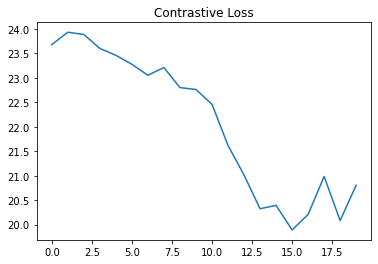

In [ ]:
from __future__ import print_function
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import random
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from statistics import mean

batch_size = 55   # Number of samples in each batch
epoch_num = 20      # Number of epochs to train the network
lr = 0.001        # Learning rate
import torch.nn.functional as F




class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(334, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.exp(F.log_softmax(x,dim=1))
        #return x



model = Model()
alpha = 0.8


# calculate the number of batches per epoch
batch_per_ep = X_train.shape[0] // batch_size

# define the loss (criterion) and create an optimizer
optimizer = optim.SGD(model.parameters(), lr=lr)

all_losses  = []
min_losses =[]
for ep in range(epoch_num):  # epochs loop
    print("..........................epoch =",ep,"..........................")
    i = 0
    for batch_n in range(batch_per_ep):  # batches loop
        batch_loss = []
       
        
        batch_1_feat = torch.FloatTensor(X_train_1[i:i+batch_size])
        batch_0_feat = torch.FloatTensor(X_train_0[i:i+batch_size])
        
        batch_label = y_train[i:i+batch_size]
        batch_Z_trans = Z_trans[i:i+batch_size]

        # Reset gradients
        # optimizer.zero_grad()

        # Forward pass
        mu_1 = model(batch_1_feat)
        mu_0 = model(batch_0_feat)

        mu_1_target_class = mu_1[:,1]
        mu_0_target_class = mu_0[:,1]

        treatment_batch = treatment_train[i:i+batch_size]
        treatment_batch = torch.from_numpy(treatment_batch).int()
        treatment_batch = Variable(treatment_batch)


        
        
        ones = np.ones(shape = batch_size)
        ones = torch.from_numpy(ones).float()
        #implements mu = T * mu_1 + (1-T) * mu_0
        uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 


        mu_0_target_class = torch.reshape(mu_0_target_class, (batch_size,1))
        mu_1_target_class = torch.reshape(mu_1_target_class, (batch_size,1))
        #convert to torch structure
        batch_label = torch.from_numpy(batch_label).float()
        batch_label = Variable(batch_label)

       
        #convert to torch structure
        batch_Z_trans = batch_Z_trans.to_numpy()
        batch_Z_trans = torch.from_numpy(batch_Z_trans).float()
        batch_Z_trans = Variable(batch_Z_trans)

        batch_Z_trans = torch.reshape(batch_Z_trans, (batch_size,1))
        
        #declare losses
        loss_cross = nn.BCELoss(reduction = 'sum')
        loss_MSE = nn.MSELoss()

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class 

        loss_contrastive =torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))

        batch_loss.append(loss_contrastive)
        
        # print(batch_n, loss_contrastive)


        optimizer.zero_grad()
        # Backward pass and updates
        loss_contrastive.backward()                     # calculate the gradients
        optimizer.step()                    # update the weights
        i += batch_size
    batch_loss  = list(batch_loss)
    all_losses.append( sum(batch_loss) / len(batch_loss)) 

import matplotlib.pyplot as plt
plt.plot(all_losses)
plt.title('Contrastive Loss')
plt.show()

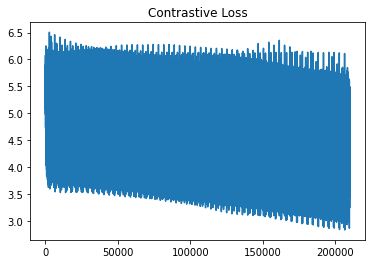

In [ ]:
import matplotlib.pyplot as plt
plt.plot(all_losses[:210000])
plt.title('Contrastive Loss')
plt.show()

another network with softmax 



In [ ]:
from __future__ import print_function
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import random
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from statistics import mean

batch_size = 55   # Number of samples in each batch
epoch_num = 19      # Number of epochs to train the network
lr = 0.001        # Learning rate
import torch.nn.functional as F




class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(334, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.exp(F.log_softmax(x,dim=1))
        #return x



model = Model()
alpha = 0.3


# calculate the number of batches per epoch
batch_per_ep = X_train.shape[0] // batch_size

# define the loss (criterion) and create an optimizer
optimizer = optim.SGD(model.parameters(), lr=lr)

X_test_1_tensor = torch.FloatTensor(X_test_1)
X_test_0_tensor = torch.FloatTensor(X_test_0)

treatment_test = treatment_test.to_numpy()
treatment_test = torch.from_numpy(treatment_test).int()
treatment_test = Variable(treatment_test)

y_test = y_test.to_numpy()
y_test = torch.from_numpy(y_test ).float()
y_test  = Variable(y_test )


#convert to torch structure
Z_trans_test = Z_trans_test.to_numpy()
Z_trans_test = torch.from_numpy(Z_trans_test).float()
Z_trans_test = Variable(Z_trans_test)

Z_trans_test = torch.reshape(Z_trans_test, (X_test_1.shape[0],1))

all_losses  = []
test_losses = []
min_losses = []
for ep in range(epoch_num):  # epochs loop
    print("..........................epoch =",ep,"..........................")
    i = 0
    for batch_n in range(batch_per_ep):  # batches loop
        batch_loss = []
       
        
        batch_1_feat = torch.FloatTensor(X_train_1[i:i+batch_size])
        batch_0_feat = torch.FloatTensor(X_train_0[i:i+batch_size])
        
        batch_label = y_train[i:i+batch_size]
        batch_Z_trans = Z_trans_train[i:i+batch_size]

        # Reset gradients
        # optimizer.zero_grad()

        # Forward pass
        mu_1 = model(batch_1_feat)
        mu_0 = model(batch_0_feat)

        mu_1_target_class = mu_1[:,1]
        mu_0_target_class = mu_0[:,1]

        treatment_batch = treatment_train[i:i+batch_size]
        treatment_batch = treatment_batch.to_numpy()
        treatment_batch = torch.from_numpy(treatment_batch).int()
        treatment_batch = Variable(treatment_batch)


        
        
        ones = np.ones(shape = batch_size)
        ones = torch.from_numpy(ones).float()
        #implements mu = T * mu_1 + (1-T) * mu_0
        uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 


        mu_0_target_class = torch.reshape(mu_0_target_class, (batch_size,1))
        mu_1_target_class = torch.reshape(mu_1_target_class, (batch_size,1))
        #convert to torch structure
        batch_label = batch_label.to_numpy()
        batch_label = torch.from_numpy(batch_label).float()
        batch_label = Variable(batch_label)

       
        #convert to torch structure
        batch_Z_trans = batch_Z_trans.to_numpy()
        batch_Z_trans = torch.from_numpy(batch_Z_trans).float()
        batch_Z_trans = Variable(batch_Z_trans)

        batch_Z_trans = torch.reshape(batch_Z_trans, (batch_size,1))
        
        #declare losses
        loss_cross = nn.BCELoss(reduction = 'sum')
        loss_MSE = nn.MSELoss()

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class 
        

        
        loss_contrastive = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
        
        batch_loss.append(loss_contrastive)
        

        
        # print(batch_n, loss_contrastive)


        optimizer.zero_grad()
        # Backward pass and updates
        loss_contrastive.backward()                     # calculate the gradients
        optimizer.step()                    # update the weights
        i += batch_size
        #end for!!!!!!!!!!!!!!!!!!!

    batch_loss  = list(batch_loss)
    all_losses.append( sum(batch_loss) / len(batch_loss)) 
    #work with test dataset

    mu_1 = model(X_test_1_tensor)
    mu_0 = model(X_test_0_tensor)

    mu_1_target_class = mu_1[:,1]
    mu_0_target_class = mu_0[:,1]

    ones = np.ones(shape = X_test_1.shape[0])
    ones = torch.from_numpy(ones).float()

    #implements mu = T * mu_1 + (1-T) * mu_0
    uplift_pred_Y = treatment_test * mu_1_target_class + (ones - treatment_test) * mu_0_target_class 

    mu_0_target_class = torch.reshape(mu_0_target_class, (X_test_1.shape[0],1))
    mu_1_target_class = torch.reshape(mu_1_target_class, (X_test_1.shape[0],1))
    

    
   
    
    #declare losses
    loss_cross = nn.BCELoss(reduction = 'sum')
    loss_MSE = nn.MSELoss()

    #implements uplift_predicted = mu_1 - mu_0
    uplift_pred = mu_1_target_class - mu_0_target_class 

    loss_contrastive =torch.mean(  (1-alpha) * loss_MSE(Z_trans_test, uplift_pred) + alpha * loss_cross( uplift_pred_Y, y_test))
    test_losses.append(loss_contrastive)
    
    print(qini_auc_score(y_test.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_test.cpu().detach().numpy() ))

import matplotlib.pyplot as plt
#plt.plot(all_losses,color='blue')
plt.plot(test_losses, color='green')
plt.title('Contrastive Loss')
plt.show()

plt.plot(all_losses,color='blue')
plt.show()

..........................epoch = 0 ..........................
-29647747.917001788
..........................epoch = 1 ..........................
-29647747.917001788
..........................epoch = 2 ..........................
-29647747.917001788
..........................epoch = 3 ..........................
-29647747.917001788
..........................epoch = 4 ..........................
